<div style="text-align: center;">
    <img src="logo.webp" alt="Logo" width="200" height="150"/>
</div>


# Introduction

EuroTravel is a specialized travel agency dedicated to crafting high-quality itineraries for clients who wish to explore Europe. Founded in response to the growing complexity of multi-city European trips—where travelers must juggle flight costs, hotel prices, train schedules, and personal preferences — EuroTravel has focused on using data-driven approaches to streamline trip planning. Over the past few years, EuroTravel has helped hundreds of travelers discover the best of Europe without the headache of manual route planning. As our client base expands, we can no longer rely on spreadsheets and intuition alone; we need a robust optimization model that selects the ideal cities, durations, and transport modes in a cost-effective manner. Hence, EuroWander is seeking to develop a new optimization tool that ensures clients’ budgetary and experience preferences are respected, while automatically generating a detailed and fully optimized European travel plan.

# Scope of the prototype

EuroTravel currently offers personalized tours across multiple European cities, taking into account factors such as hotel class, flight versus train cost, user’s daily budget, and even temperature preferences for each location. As the business has grown, the complexity of meeting client demands—like including at least one beach city or restricting daily lodging to a certain maximum—has become unmanageable with manual methods.

This prototype therefore aims to formulate an Integer Linear Programming (ILP) model that extends the traditional TSP by:

- Choosing which subset of cities to visit out of a potential list of dozens of European destinations (selective TSP).
- Determining how many nights (days) to spend in each chosen city.
- Respecting an overall budget that combines both transport and lodging expenses.
- Incorporating additional preferences, such as temperature ranges, minimum number of cities, or special requirements like visiting a beach or mountain city.
- Optimizing the route itself by selecting cost-effective arcs between cities, ensuring we end up with one valid cycle that starts and ends at the user’s specified city (TSP cycle requirement).
- 
Ultimately, this prototype will serve as the baseline for EuroTravel’s next-generation trip-planning platform, allowing further expansions such as real-time airline APIs, dynamic pricing, advanced constraints like carbon footprints, and more sophisticated TSP extensions (multi-depot or multi-tour variants).


# The Data

To build the prototype, we have used main datasets:

- City Dataset (European_Cities_With_Coordinates.csv)
This dataset contains essential information about each European city, such as its name, latitude, longitude, average temperature, daily lodging cost (budget, mid-range, or luxury), and whether it is considered a beach or mountain city. It also has an “Avg_Budget_Per_Day_EUR” column, indicating typical daily spending by an average traveler. This allows us to determine which cities meet user preferences (e.g., temperature range or daily lodging limit) and how much it will cost to stay in each location.

- Routes Dataset (Travel_Routes_Augmented_Real.csv)
This dataset describes possible connections between any two European cities, specifying the cost and time for flights, trains, and buses. For each route, we store the cheapest available cost, and if multiple modes share the same cost, we pick the fastest option. This data enables us to decide how to link cities in an itinerary, whether it’s cheaper to fly or take the train, and how much time is spent traveling. It effectively provides the graph on which our TSP-based model is built.

## 1. Loading Libraries and Data

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import PolyLineTextPath
from IPython.display import display
import gurobipy as gp
from gurobipy import GRB, quicksum

In [10]:
df_routes = pd.read_csv("Travel_Routes_Augmented_Real.csv")
df_cities = pd.read_csv("European_Cities_With_Coordinates.csv")

## 2. Exploratory Data Analysis (EDA)

In [12]:
print("Routes shape:", df_routes.shape)
print("Cities shape:", df_cities.shape)

na_routes = df_routes.isna().sum()
na_cities = df_cities.isna().sum()

# Display the number of missing values in each column
print("Missing values in Travel_Routes_Augmented_Real.csv:")
print(na_routes)
print("\nMissing values in European_Cities_With_Coordinates.csv:")
print(na_cities)

Routes shape: (116, 11)
Cities shape: (30, 11)
Missing values in Travel_Routes_Augmented_Real.csv:
From               0
From_Country       0
To                 0
To_Country         0
Distance_km        0
Flight_Time_hr     0
Train_Time_hr      0
Bus_Time_hr        0
Flight_Cost_EUR    0
Train_Cost_EUR     0
Bus_Cost_EUR       0
dtype: int64

Missing values in European_Cities_With_Coordinates.csv:
City                      0
Beach                     0
Mountain                  0
Avg_Budget_Per_Day_EUR    0
Budget_Hotel_EUR          0
Mid_Range_Hotel_EUR       0
Luxury_Hotel_EUR          0
Avg_Rating                0
Avg_Temperature_C         0
Latitude                  0
Longitude                 0
dtype: int64


- There are 116 rows and 11 columns for the Travel Routes Dataset, and 30 rows and 11 columns for the Cities dataset.
- There are no missing values in any of the columns.

Next, we will explore the 2 datasets separately.

### 2.1 City Data

In [16]:
print("Info:")
print(df_cities.info())

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    30 non-null     object 
 1   Beach                   30 non-null     int64  
 2   Mountain                30 non-null     int64  
 3   Avg_Budget_Per_Day_EUR  30 non-null     int64  
 4   Budget_Hotel_EUR        30 non-null     int64  
 5   Mid_Range_Hotel_EUR     30 non-null     int64  
 6   Luxury_Hotel_EUR        30 non-null     int64  
 7   Avg_Rating              30 non-null     float64
 8   Avg_Temperature_C       30 non-null     int64  
 9   Latitude                30 non-null     float64
 10  Longitude               30 non-null     float64
dtypes: float64(3), int64(7), object(1)
memory usage: 2.7+ KB
None


Info let's us clearly see the 11 columns in the Cities dataset:
- City: the name of the city
- Beach: 0 (if the city doesn't have a beach) or 1 (if the city has at least a beach)
- Mountain: 0 (if the city isn't near a mountain) or 1 (if the city is near a mountain)
- Avg_Budget_Per_Day_EUR: the average budget recommended per day for food, attractions etc.
- Budget_Hotel_EUR, Mid_Range_Hotel_EUR,Luxury_Hotel_EUR: the price per night of the hotel for each category
- Avg_Rating: average rating (1-5) of the hotels
- Avg_Temperature_C: average summer temperatures in Celsuis
- Latitude, Longitude: city coordinates 

In [18]:
print("\nHead of df_cities:")
print(df_cities.head())


Head of df_cities:
        City  Beach  Mountain  Avg_Budget_Per_Day_EUR  Budget_Hotel_EUR  \
0  Amsterdam      0         0                      80                60   
1     Athens      1         0                      60                50   
2  Barcelona      1         0                      70                45   
3     Berlin      0         0                      70                40   
4   Brussels      0         0                      70                45   

   Mid_Range_Hotel_EUR  Luxury_Hotel_EUR  Avg_Rating  Avg_Temperature_C  \
0                  120               250         4.5                 21   
1                   90               220         4.7                 33   
2                  100               250         4.6                 35   
3                   90               220         4.5                 24   
4                  110               250         4.3                 22   

   Latitude  Longitude  
0   52.3676     4.9041  
1   37.9838    23.7275  
2  

In [19]:
print("\nDescribe df_cities numeric columns:")
print(df_cities.describe())


Describe df_cities numeric columns:
           Beach   Mountain  Avg_Budget_Per_Day_EUR  Budget_Hotel_EUR  \
count  30.000000  30.000000               30.000000          30.00000   
mean    0.333333   0.133333               75.166667          53.00000   
std     0.479463   0.345746               16.634164          14.53889   
min     0.000000   0.000000               50.000000          30.00000   
25%     0.000000   0.000000               60.000000          41.25000   
50%     0.000000   0.000000               70.000000          50.00000   
75%     1.000000   0.000000               87.500000          60.00000   
max     1.000000   1.000000              110.000000          80.00000   

       Mid_Range_Hotel_EUR  Luxury_Hotel_EUR  Avg_Rating  Avg_Temperature_C  \
count            30.000000         30.000000   30.000000          30.000000   
mean            111.666667        261.333333    4.423333          25.500000   
std              25.200347         49.808830    0.181342           5

In [20]:
if "Beach" in df_cities.columns:
    print("\nBeach distribution:\n", df_cities["Beach"].value_counts())
if "Mountain" in df_cities.columns:
    print("\nMountain distribution:\n", df_cities["Mountain"].value_counts())



Beach distribution:
 Beach
0    20
1    10
Name: count, dtype: int64

Mountain distribution:
 Mountain
0    26
1     4
Name: count, dtype: int64


There are 10 cities which have at least a beach, and 4 cities which have mountains in our dataset.

### 2.2 City Data Vizualization

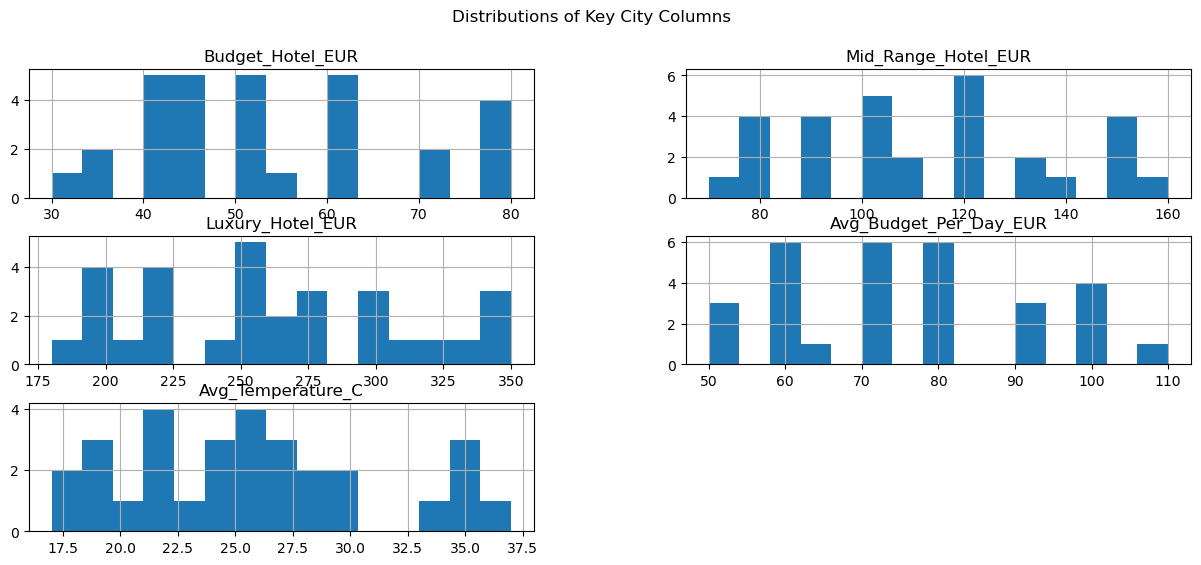

In [23]:
numeric_cols = ["Budget_Hotel_EUR","Mid_Range_Hotel_EUR","Luxury_Hotel_EUR","Avg_Budget_Per_Day_EUR","Avg_Temperature_C"]
if numeric_cols:
        df_cities[numeric_cols].hist(bins=15, figsize=(15,6))
        plt.suptitle("Distributions of Key City Columns")
        plt.show()

Hotel costs vary significantly across budget, mid-range, and luxury options, with budget hotels mostly between €30-80, mid-range hotels around €80-160, and luxury hotels ranging widely between €175-350. Average daily travel budgets also show variation, generally falling between €50-110, while average city temperatures cluster mostly between 8-14°C, which could influence seasonal travel decisions.

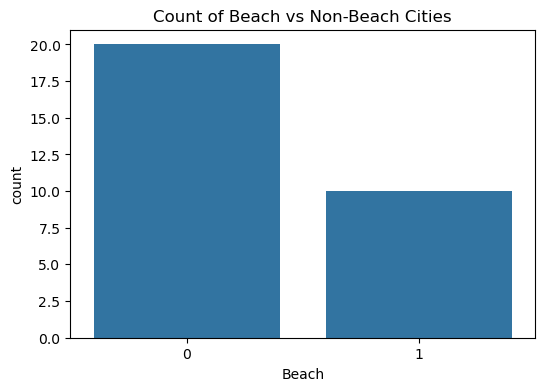

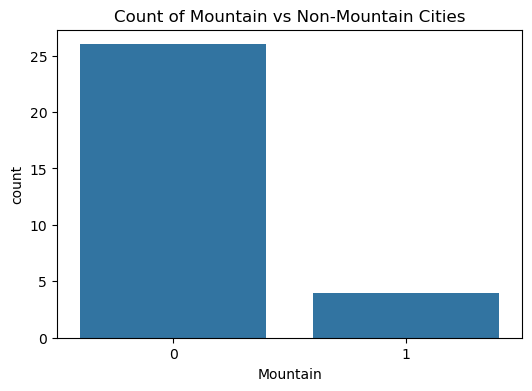

In [25]:
if "Beach" in df_cities.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="Beach", data=df_cities)
    plt.title("Count of Beach vs Non-Beach Cities")
    plt.show()

if "Mountain" in df_cities.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="Mountain", data=df_cities)    
    plt.title("Count of Mountain vs Non-Mountain Cities")
    plt.show()


2.3 Route Data

In [27]:
print("Info:")
print(df_routes.info())

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   From             116 non-null    object 
 1   From_Country     116 non-null    object 
 2   To               116 non-null    object 
 3   To_Country       116 non-null    object 
 4   Distance_km      116 non-null    int64  
 5   Flight_Time_hr   116 non-null    float64
 6   Train_Time_hr    116 non-null    float64
 7   Bus_Time_hr      116 non-null    float64
 8   Flight_Cost_EUR  116 non-null    int64  
 9   Train_Cost_EUR   116 non-null    int64  
 10  Bus_Cost_EUR     116 non-null    int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 10.1+ KB
None


There are 11 columns in the Routes dataset:
- From: origin city
- From_Countru: origin country
- To: destination city
- To_Country: destination country
- Distance_km: distance in km between the two cities
- Flight_Time_hr, Train_Time_hr, Bus_Time_hr: time in hours it takes to reach the destination city from the origin city
- Flight_Cost_EUR, Train_Cost_EUR, Bus_Cost_EUR: ticket cost for each mode of transportation 

In [29]:
print("\nHead of df_routes:")
print(df_routes.head())


Head of df_routes:
        From From_Country         To      To_Country  Distance_km  \
0  Amsterdam  Netherlands  Reykjavik         Iceland         2100   
1     Madrid        Spain   Valencia           Spain          360   
2     Berlin      Germany     Prague  Czech Republic          350   
3       Rome        Italy   Florence           Italy          280   
4     Madrid        Spain    Seville           Spain          530   

   Flight_Time_hr  Train_Time_hr  Bus_Time_hr  Flight_Cost_EUR  \
0             3.2            0.0          0.0              120   
1             1.0            2.0          4.0               40   
2             1.0            4.5          5.5               45   
3             0.8            2.0          4.0               45   
4             1.1            2.5          6.0               45   

   Train_Cost_EUR  Bus_Cost_EUR  
0               0             0  
1              30            15  
2              40            20  
3              35            20 

In [30]:
print("\nDescribe df_routes numeric columns:")
print(df_routes.describe())


Describe df_routes numeric columns:
       Distance_km  Flight_Time_hr  Train_Time_hr  Bus_Time_hr  \
count   116.000000      116.000000     116.000000   116.000000   
mean   1250.034483        2.060345       8.410345    16.942241   
std     758.168846        0.952788       4.680345     9.446942   
min     173.000000        0.700000       0.000000     0.000000   
25%     677.000000        1.300000       4.700000     9.375000   
50%    1099.000000        1.900000       7.850000    15.600000   
75%    1640.000000        2.525000      11.625000    23.400000   
max    4163.000000        5.700000      20.800000    52.000000   

       Flight_Cost_EUR  Train_Cost_EUR  Bus_Cost_EUR  
count       116.000000      116.000000    116.000000  
mean         86.086207      106.163793     63.181034  
std          38.323467       56.946954     36.411321  
min          40.000000        0.000000      0.000000  
25%          59.000000       65.000000     40.000000  
50%          76.000000       95.000000

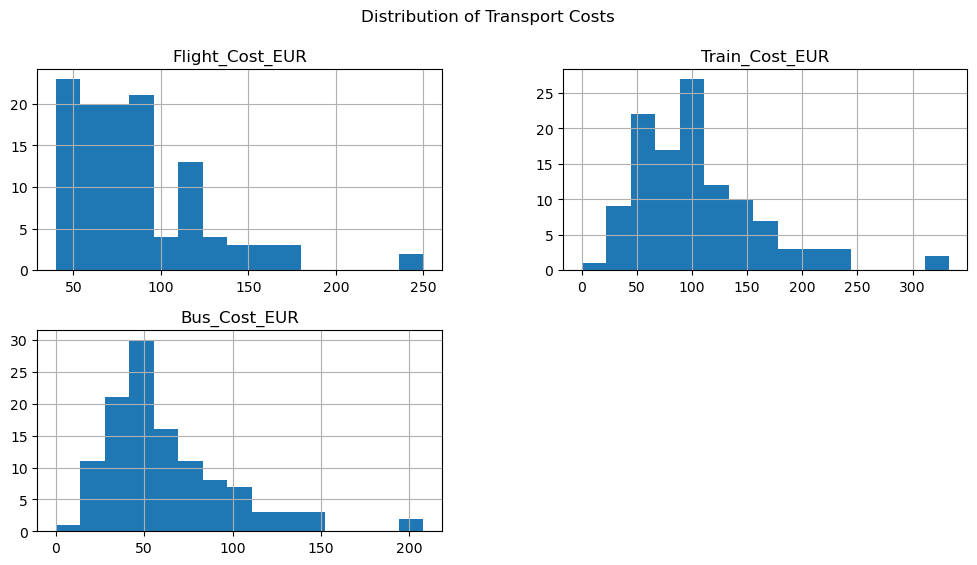

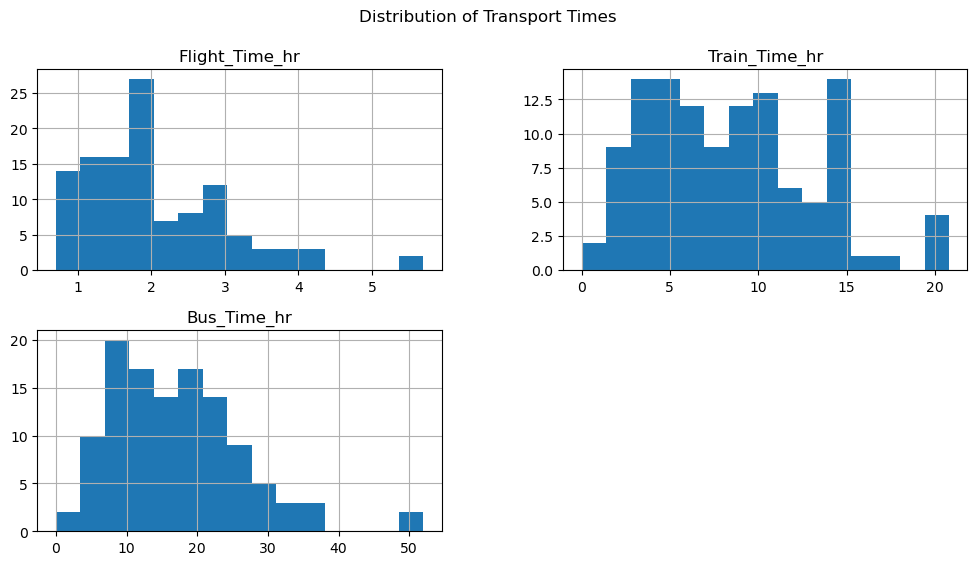

In [31]:
cost_cols = ["Flight_Cost_EUR","Train_Cost_EUR","Bus_Cost_EUR"]
cost_cols = [c for c in cost_cols if c in df_routes.columns]
if cost_cols:
    df_routes[cost_cols].hist(bins=15, figsize=(12,6))
    plt.suptitle("Distribution of Transport Costs")
    plt.show()

time_cols = ["Flight_Time_hr","Train_Time_hr","Bus_Time_hr"]
time_cols = [c for c in time_cols if c in df_routes.columns]
if time_cols:
    df_routes[time_cols].hist(bins=15, figsize=(12,6))
    plt.suptitle("Distribution of Transport Times")
    plt.show()


From the graphs above we can see that Flight_Cost_EUR distribution shows a concentration of lower-cost flights around €50-100, with a few outliers above €200. The Train_Cost_EUR and Bus_Cost_EUR distributions are more spread out, with many train tickets ranging between €50-150 and bus tickets clustering under €100, making buses the most budget-friendly option.
 Flight times are mostly concentrated between 1-3 hours, making it the fastest mode of transport, while train times vary widely, peaking around 5-10 hours, with some journeys exceeding 15 hours. Bus travel times are significantly longer, often ranging between 10-30 hours, with a few extreme cases exceeding 50 hours, indicating that buses are the slowest but the cheapest travel option.

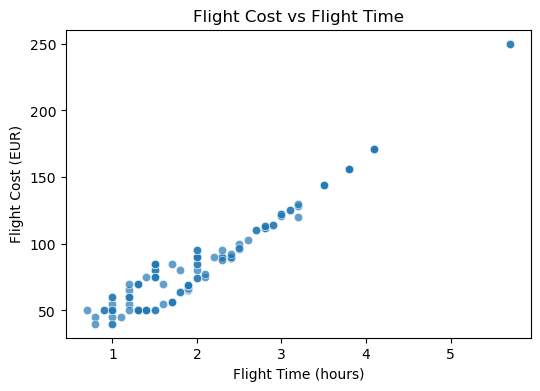

In [33]:
if "Flight_Cost_EUR" in df_routes.columns and "Flight_Time_hr" in df_routes.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(
            data=df_routes,
            x="Flight_Time_hr",
            y="Flight_Cost_EUR",
            alpha=0.7
        )
        plt.title("Flight Cost vs Flight Time")
        plt.xlabel("Flight Time (hours)")
        plt.ylabel("Flight Cost (EUR)")
        plt.show()


Longer flights cost more, meaning that farther away destinations will be more expensive. This means that it would probably be better to start with closer destinations.

## 3. Data Setup

Convert city names to indices for easier modeling

In [37]:
city_list = df_cities["City"].tolist()
n = len(city_list)
city_index = {name: idx for idx, name in enumerate(city_list)}
print(city_index, "    ", n)

{'Amsterdam': 0, 'Athens': 1, 'Barcelona': 2, 'Berlin': 3, 'Brussels': 4, 'Budapest': 5, 'Copenhagen': 6, 'Dublin': 7, 'Florence': 8, 'Geneva': 9, 'Hamburg': 10, 'Lisbon': 11, 'London': 12, 'Luxembourg City': 13, 'Madrid': 14, 'Milan': 15, 'Munich': 16, 'Oslo': 17, 'Paris': 18, 'Prague': 19, 'Reykjavik': 20, 'Rome': 21, 'Seville': 22, 'Stockholm': 23, 'Valencia': 24, 'Venice': 25, 'Vienna': 26, 'Warsaw': 27, 'Zagreb': 28, 'Zurich': 29}      30


In [38]:
transportation_modes = ["plane", "train", "bus"]

Creating two sets: one for the cities that have at least a beach and one for the cities which are near the mountains 

In [40]:
beach_set = set()
mountain_set = set()
if "Beach" in df_cities.columns:
    for i, row in df_cities.iterrows():
        if row["Beach"] == 1:
            beach_set.add(i)

if "Mountain" in df_cities.columns:
    for i, row in df_cities.iterrows():
        if row["Mountain"] == 1:
            mountain_set.add(i)

## 4. Model Creation

## Sets

Let:
$$
C = \{0,1,\dots,n-1\}
$$
be the set of all city indices.

Let:
$$
s \in C
$$
be the start city index.

## Parameters

- **Travel cost**:  
  $$ \text{cost}[i,j] $$  
  Travel cost from city $i$ to city $j$.  
  **In code:** `travel_cost[(i,j)]`

- **Lodging cost**:  
  $$ \text{lodging}[i] $$  
  Lodging cost per night in city $i$.  
  **In code:** `lodging_cost_dict[i]`

- **Total number of days**:  
  $$ T $$  
  **In code:** `total_days`

- **User budget**:  
  $$ \beta $$  
  **In code:** `user_budget`

- **Minimum number of visited cities**:  
  $$ \text{min\_cities} $$  
  **In code:** `min_cities`

- **Fraction for maximum nights in a single city**:  
  $$ \alpha \times T $$  
  **In code:** `diversity_fraction`

- **Set of beach cities** (if `need_beach=True`):  
  $$ B \subseteq C $$

- **Set of mountain cities** (if `need_mountain=True`):  
  $$ M \subseteq C $$


  ## Decision Variables

- **Direct arc between cities**:  
  $$ x_{i,j} \in \{0,1\} $$  
  1 if the solution includes a direct arc from city $i$ to city $j$, 0 otherwise.  
  **In code:** `x[(i,j)]`

- **City visit indicator**:  
  $$ y_i \in \{0,1\} $$  
  1 if city $i$ is visited, 0 otherwise.  
  **In code:** `y[i]`

- **Number of nights spent in city**:  
  $$ s_i \in \mathbb{Z}_{\geq 0} $$  
  Integer number of nights spent in city $i$.  
  **In code:** `s_var[i]`


  ## Objective

  Minimize total cost:

$$
\min \left( 
\underbrace{\sum_{(i,j)} \text{cost}[i,j] \cdot x_{i,j}}_{\text{travel cost}}
+
\underbrace{\sum_{i} \text{lodging}[i] \cdot s_i}_{\text{lodging cost}}
\right)
$$
  ## Constraints

  ### 1. Start City Visited
$$
y_s = 1
$$
  ### 2. Flow for the Start City

$$
\sum_{k \neq s} x_{k,s} = 1, \quad \sum_{k \neq s} x_{s,k} = 1
$$

One arc in, one arc out, for city $s$.

  ### 3. Flow for Other Cities
For each $ i \neq s $:
$$
\sum_{k \neq i} x_{k,i} = y_i, \quad \sum_{k \neq i} x_{i,k} = y_i
$$
If city $ i $ is visited ($ y_i = 1 $), exactly one arc enters and leaves. If not visited, no arcs.


  ### 4. No Arcs if Not Visited

$$
x_{i,j} \leq y_i, \quad x_{i,j} \leq y_j, \quad \forall i \neq j
$$
  ### 5. Beach / Mountain Requirement

If `need_beach = True`:

$$
\sum_{i \in B} y_i \geq 1
$$

If `need_mountain = True`:

$$
\sum_{i \in M} y_i \geq 1
$$
  ### 6. Total Days

$$
\sum_{i} s_i = T
$$
  ### 7. At Least 1 Night if Visited

$$
s_i \geq y_i, \quad \forall i
$$
  ### 8. (Optional) Upper Bound on Nights

Often the code enforces:

$$
s_i \leq 30 y_i \quad \text{(or some large } M \text{)}
$$

so that if $ y_i = 0 $, then $ s_i = 0 $. Alternatively, this constraint may be handled by other conditions.


  ### 9. Minimum Number of Visited Cities

$$
\sum_{i} y_i \geq \text{min\_cities}
$$

  ### 10. Budget Constraint

$$
\sum_{(i,j)} \text{cost}[i,j] \cdot x_{i,j} + \sum_{i} \text{lodging}[i] \cdot s_i \leq \beta
$$
  ### 11. Diversity Constraint

$$
s_i \leq \alpha \cdot T, \quad \forall i
$$

  ### 12. Subtour Elimination (Lazy Callback)

In the code, a callback is used to forbid any subset $ S \subset C $ that excludes $ s $ from forming a cycle.  
Mathematically, a common approach is:

$$
\sum_{i,j \in S} x_{i,j} \leq |S| - 1, \quad \text{for any subset } S \text{ of visited cities not containing } s.
$$

The code uses a Depth-First Search (DFS) to detect a visited subset $ S $ that forms a cycle, then adds a lazy constraint.


### 4.1 Model Initialization

In [44]:
m = gp.Model("europe_trip")

Set parameter Username
Set parameter LicenseID to value 2607094
Academic license - for non-commercial use only - expires 2026-01-07


### 4.2 Function which builds the whole model

In [46]:
def selectCities(
    start_city_name,
    total_days,
    df_routes = df_routes,
    df_cities = df_cities,
    beach_set = beach_set,            
    mountain_set = mountain_set,          
    transport_mode=None,   # "Flight", "Train", "Bus", or None => combine all
    user_budget=999999,    # total cost + lodging must not exceed this
    need_beach=False,      # True if the customer wants at least one city to have a beach
    need_mountain=False,   # True if the customer wants at least one city to have mountains
    min_cities=2,          # min number of cities to be visited on the trip
    user_min_temp=None,    # min temperature user tolerates
    user_max_temp=None,    # max temperature user tolerates
    hotel_type=None,       # "budget", "mid_range", or "luxury"
    user_daily_lodging_max=None,
    diversity_fraction=0.5 # to calibrate the allocation of days / city
):
    """
    A selective TSP cycle model that references:
      - df_routes, df_cities loaded from outside
      - beach_set, mountain_set built outside (for i where Beach=1 or Mountain=1)
    Minimizes (travel_cost + lodging_cost)
    Returns a dict with solution details.
    """
    
    if start_city_name not in city_index:
        raise ValueError(f"Start city '{start_city_name}' not found in df_cities.")
    start_idx = city_index[start_city_name]

    # Build cost/time dictionaries + winning_mode
    valid_modes = ["Flight","Train","Bus"]
    travel_cost = {}
    travel_time = {}
    winning_mode = {}

    # Process the travel routes and populate cost/time dictionaries
    for row in df_routes.itertuples():
        from_city = getattr(row, "From")
        to_city   = getattr(row, "To")
        if from_city in city_index and to_city in city_index:
            i = city_index[from_city]
            j = city_index[to_city]
            if i == j:
                continue
            # If the user selected a travel transportation preference, 
            #then the transport mode will be in valid_modes
            if transport_mode in valid_modes:
                # single mode
                cost_col = transport_mode + "_Cost_EUR"
                time_col = transport_mode + "_Time_hr"
                if hasattr(row, cost_col) and hasattr(row, time_col):
                    c_val = getattr(row, cost_col)
                    t_val = getattr(row, time_col)
                    if c_val < 1e6 and t_val < 1e6:
                        travel_cost[(i,j)] = c_val
                        travel_time[(i,j)] = t_val
                        winning_mode[(i,j)] = transport_mode
            # If the user doesn't have a preference, then the model will choose the cheapest transport option
            else:
                    # Combine => pick minimal cost; if tie, pick minimal time
                    flight_c = getattr(row, "Flight_Cost_EUR", 1e6)
                    train_c  = getattr(row, "Train_Cost_EUR",  1e6)
                    bus_c    = getattr(row, "Bus_Cost_EUR",    1e6)
                
                    flight_t = getattr(row, "Flight_Time_hr",  1e6)
                    train_t  = getattr(row, "Train_Time_hr",   1e6)
                    bus_t    = getattr(row, "Bus_Time_hr",     1e6)
                
                    # Build a list of feasible (cost, time, mode)
                    candidates = []
                    if flight_c < 1e6 and flight_t < 1e6:
                        candidates.append((flight_c, flight_t, "Flight"))
                    if train_c < 1e6 and train_t < 1e6:
                        candidates.append((train_c, train_t, "Train"))
                    if bus_c < 1e6 and bus_t < 1e6:
                        candidates.append((bus_c, bus_t, "Bus"))
                
                    # If we have at least one feasible mode, pick the one with minimal (cost, time)
                    if candidates:
                        best_cost, best_time, best_mode = min(candidates, key=lambda x: (x[0], x[1]))
                        travel_cost[(i,j)] = best_cost
                        travel_time[(i,j)] = best_time
                        winning_mode[(i,j)] = best_mode


    # Decide lodging cost column based on what the user selected
    if hotel_type == "luxury":
        lodging_col = "Luxury_Hotel_EUR"
    elif hotel_type == "mid_range":
        lodging_col = "Mid_Range_Hotel_EUR"
    else:
        lodging_col = "Budget_Hotel_EUR"  # default

    if lodging_col not in df_cities.columns:
        raise ValueError(f"No column '{lodging_col}' in df_cities.")

    lodging_cost_dict = {}
    for i, row in df_cities.iterrows():
        lodging_cost_dict[i] = row[lodging_col]

    # recommended daily spend
    avg_daily_spend = {}
    if "Avg_Budget_Per_Day_EUR" in df_cities.columns:
        for i, row in df_cities.iterrows():
            avg_daily_spend[i] = row["Avg_Budget_Per_Day_EUR"]
    else:
        for i in range(n):
            avg_daily_spend[i] = 0

    # Temperature filter => build feasible_cities
    feasible_cities = set(range(n))
    if "Avg_Temperature_C" in df_cities.columns:
        for i, row in df_cities.iterrows():
            temp = row["Avg_Temperature_C"]
            if user_min_temp is not None and temp < user_min_temp:
                feasible_cities.remove(i)
            if user_max_temp is not None and temp > user_max_temp:
                feasible_cities.remove(i)
    # Ensures the trip is always possible, even if the start city falls outside the user's temperature range
    feasible_cities.add(start_idx)

    # Filtering out cities exceeding daily lodging max
    if user_daily_lodging_max is not None:
        for i in list(feasible_cities):
            if lodging_cost_dict[i] > user_daily_lodging_max and i != start_idx:
                feasible_cities.remove(i)

    # Build model
    m = gp.Model("europe_trip")

    # Decision variables
    # cities visited
    y = {}
    for i in range(n):
        y[i] = m.addVar(vtype=GRB.BINARY, name=f"visit_{i}")
        if i not in feasible_cities:
            # force y[i] = 0 if city is infeasible
            y[i].ub = 0
    # number of nights per city
    s_var = m.addVars(n, vtype=GRB.INTEGER, lb=0, name="days")

    # arcs -> direct route between cities
    x = {}
    for (i,j) in travel_cost.keys():
        if i in feasible_cities or i==start_idx:
            if j in feasible_cities or j==start_idx:
                x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

    # Objective
    # We want to minimize total cost: travel and lodging
    travel_cost_expr = quicksum(travel_cost[(i,j)] * x[(i,j)] for (i,j) in x.keys())
    lodging_cost_expr = quicksum(lodging_cost_dict[i]*s_var[i] for i in range(n))
    total_expr = travel_cost_expr + lodging_cost_expr
    m.setObjective(total_expr, GRB.MINIMIZE)

    # Constraints

    # 1. Start city is visited
    m.addConstr(y[start_idx] == 1, "start_visited")

    def inflow(i):
        return quicksum(x[(k,i)] for (k,i_) in x.keys() if i_==i)
    def outflow(i):
        return quicksum(x[(i,j)] for (i_,j) in x.keys() if i_==i)
        
    # 2. Flow for the Start City: one arc in, one arc out
    m.addConstr(inflow(start_idx) == 1, "inflow_start")
    m.addConstr(outflow(start_idx) == 1, "outflow_start")

    # 3. If city  is visited (), exactly one arc enters and leaves. If not visited, no arcs.
    for i in range(n):
        if i == start_idx:
            continue
        m.addConstr(inflow(i) == y[i], f"inflow_{i}")
        m.addConstr(outflow(i) == y[i], f"outflow_{i}")
    # 4. No Arcs if Not Visited
    for (i,j) in x.keys():
        m.addConstr(x[(i,j)] <= y[i], f"x_le_yi_{i}_{j}")
        m.addConstr(x[(i,j)] <= y[j], f"x_le_yj_{i}_{j}")

    # 5. Beach / Mountain Requirement
    if need_beach and beach_set:
        m.addConstr(quicksum(y[i] for i in beach_set if i in feasible_cities) >= 1, "need_beach")

    if need_mountain and mountain_set:
        m.addConstr(quicksum(y[i] for i in mountain_set if i in feasible_cities) >= 1, "need_mountain")
    # 6. Total Days
    m.addConstr(quicksum(s_var[i] for i in range(n)) == total_days, "sum_days_eq_total")
    for i in range(n):
        # 7. At Least 1 Night if Visited
        m.addConstr(s_var[i] >= y[i], f"min_days_{i}")
        # 8. (Optional) Upper Bound on Nights -> if y = 0, then s = 0 (can't spend nights if city is not visited)
        m.addConstr(s_var[i] <= 30*y[i], f"max_days_{i}")
    # 9. Minimum Number of Visited Cities
    m.addConstr(quicksum(y[i] for i in range(n)) >= min_cities, "min_cities")
    # 10. Budget Constraint
    m.addConstr(travel_cost_expr + lodging_cost_expr <= user_budget, "budgetConstraint")

    # 11. Diversity Constraint (so the model doesn't allocate the majority of days to the same city)
    for i in range(n):
        m.addConstr(s_var[i] <= diversity_fraction*total_days, f"diversity_{i}")

    # 12. Subtour Elimination (Lazy Callback)
    # ensures that all visited cities are part of a single connected component that includes the start city
    def subtour_callback(model, where):
        # the function is called when a new integer feasible solution (MIPSOL) is found
        if where == GRB.Callback.MIPSOL:
            # Extracts values for decision variables x and y
            sol_x = {}
            sol_y = {}
            for (i_,j_) in model._xvars.keys():
                sol_x[(i_,j_)] = model.cbGetSolution(model._xvars[(i_,j_)])
            for i_ in range(n):
                sol_y[i_] = model.cbGetSolution(model._yvars[i_])
                
            # Builds the Graph Representation
            # adjacency list to store which cities are connected in the current solution.
            adj = {node: set() for node in range(n)}
            for (i_,j_) in sol_x.keys():
                if sol_x[(i_,j_)] > 0.5:
                    adj[i_].add(j_)
                    adj[j_].add(i_)

            visited_nodes = set(i_ for i_ in range(n) if sol_y[i_]>0.5)
            visited_cc = set()
            # Identify Connected Components Using DFS
            def dfs(root):
                stack = [root]
                comp = []
                while stack:
                    node = stack.pop()
                    if node not in visited_cc:
                        visited_cc.add(node)
                        comp.append(node)
                        for nxt in adj[node]:
                            if nxt not in visited_cc:
                                stack.append(nxt)
                return comp

            # check for subtours not containing start city
            if visited_nodes:
                for node in visited_nodes:
                    if node not in visited_cc:
                        comp = dfs(node)
                        if start_idx not in comp and len(comp)>1:
                            # lhs_expr counts the number of edges within the detected subtour
                            lhs_expr = gp.LinExpr()
                            sum_y_comp = sum(sol_y[i_] for i_ in comp)
                            for i_ in comp:
                                for j_ in comp:
                                    if (i_, j_) in model._xvars and i_!=j_:
                                        lhs_expr.addTerms(1.0, model._xvars[(i_, j_)])
                            # Ensures that not all the cities in comp can form a separate cycle
                            # Forces at least one connection to a city outside comp, eliminating the subtour
                            model.cbLazy(lhs_expr <= sum_y_comp - 1)

    # Store Decision Variables in m
    m._xvars = x
    m._yvars = y
    # Enable Lazy Constraints
    m.Params.LazyConstraints = 1

    # Optimizing the model
    m.optimize(subtour_callback)

    # Creating variables useful for the model output
    arcs_used = []
    route = []
    visited_cities_list = []
    day_alloc = [0]*n
    total_travel_time = 0.0
    recommended_spend_sum = 0.0

    if m.status == GRB.OPTIMAL:
        visited_cities_list = [i for i in range(n) if y[i].X>0.5]
        day_alloc = [int(s_var[i].X) for i in range(n)]

        # reconstruct route
        route = [start_idx]
        current = start_idx
        while True:
            nxt = None
            for j in range(n):
                if (current,j) in x and x[(current,j)].X>0.5:
                    nxt = j
                    arcs_used.append((current,j))
                    break
            if nxt is None or nxt==start_idx:
                route.append(start_idx)
                break
            route.append(nxt)
            current = nxt

        # compute total travel time
        for (i_, j_) in arcs_used:
            t_val = travel_time.get((i_, j_), 0.0)
            total_travel_time += t_val

        # sum recommended daily spend from 'Avg_Budget_Per_Day_EUR'
        for i in range(n):
            recommended_spend_sum += avg_daily_spend[i]*day_alloc[i]

        return {
            "status": m.status,
            "objective": m.objVal,
            "visited_indices": visited_cities_list,
            "visited_names": [city_list[i] for i in visited_cities_list],
            "days_per_city": day_alloc,
            "travel_cost": travel_cost_expr.getValue(),
            "lodging_cost": lodging_cost_expr.getValue(),
            "route": route,
            "arcs_used": arcs_used,
            "total_travel_time": total_travel_time,
            "recommended_spend": recommended_spend_sum,
            "winning_mode": winning_mode,
            "travel_time_dict": travel_time
        }
    else:
        return {"status": m.status}


### 4.3 Calling the function

In [48]:
solution = selectCities(
        start_city_name="Paris",
        total_days= 10,
        transport_mode="Flight", 
        user_budget=5500,
        need_beach= True,
        need_mountain=True,
        min_cities = 4,
        user_min_temp=10,
        user_max_temp=35,
        hotel_type="luxury",
        user_daily_lodging_max=None,
        diversity_fraction=0.5
    )


Set parameter LazyConstraints to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
LazyConstraints  1

Optimize a model with 380 rows, 172 columns and 1096 nonzeros
Model fingerprint: 0xf8d2d289
Variable types: 0 continuous, 172 integer (142 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [4e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+03]
Presolve removed 264 rows and 10 columns
Presolve time: 0.00s
Presolved: 116 rows, 162 columns, 589 nonzeros
Variable types: 0 continuous, 162 integer (133 binary)

Root relaxation: objective 2.757500e+03, 73 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2757.5

### 4.4 Function which displays key metrics of the optimal route

In [50]:
def display_model_output(solution, df_cities):
    """
    Displays a summary of the optimization model's output, including travel details,
    costs, and route information.

    Solution: dict
        Contains keys:
        - "status": Optimization status (checks if an optimal solution is found).
        - "objective": Total cost including travel and lodging.
        - "visited_indices": List of indices of visited cities.
        - "visited_names": List of names of visited cities.
        - "days_per_city": Dictionary mapping city indices to the number of nights stayed.
        - "travel_cost": Total cost associated with traveling.
        - "lodging_cost": Total cost associated with lodging.
        - "route": Ordered list of visited city indices.
        - "arcs_used": Set of connections (city-to-city travel).
        - "total_travel_time": Total duration spent traveling.
        - "recommended_spend": Suggested daily budget.
        - "winning_mode": Dictionary mapping city pairs (i, j) to transportation modes.
        - "travel_time_dict": Dictionary mapping city pairs (i, j) to travel time.
    """
    # Ensure the solution is optimal before proceeding
    if solution["status"] != GRB.OPTIMAL:
        print("No feasible solution found.")
        return

    # Basic summary
    print(f"Optimal objective (Cost+Lodging): {solution['objective']:.2f}")
    print(f"Visited city indices: {solution['visited_indices']}")
    print(f"Visited city names: {solution['visited_names']}")
    print(f"Days per city: {solution['days_per_city']}")
    print(f"Total Travel Cost = {solution['travel_cost']:.2f}")
    print(f"Total Lodging Cost= {solution['lodging_cost']:.2f}")

    # Extracting route details
    route = solution["route"]  # List of city indices in the travel order
    arcs_used = solution["arcs_used"]  # Set of connections between cities
    total_time = solution["total_travel_time"]  # Cumulative travel time
    recommended_spend = solution["recommended_spend"]  # Suggested daily spending budget


    # Convert city indices to city names for better readability
    route_names = [df_cities.loc[i, "City"] for i in route]
    print("Cycle route:", " -> ".join(route_names))
    # Display details of each travel connection (arcs)
    print("\nArcs used and travel times:")
    for (i_, j_) in arcs_used:
        # Retrieve the mode of transportation for this segment
        mode_str = solution["winning_mode"].get((i_, j_), "Unknown")
        # retrieve time from travel_time_dict
        time_val = solution["travel_time_dict"].get((i_, j_), 0.0)
        print(f"  {df_cities.loc[i_, 'City']} -> {df_cities.loc[j_, 'City']} via {mode_str}, time={time_val:.2f} hr")
    
    # Display the final computed travel statistics
    print(f"\nTotal Travel Time (hours) = {total_time:.2f}")
    print(f"Total recommended daily spend (Avg_Budget_Per_Day_EUR) = {recommended_spend:.2f}")



In [51]:
display_model_output(solution, df_cities)

Optimal objective (Cost+Lodging): 2873.00
Visited city indices: [0, 1, 3, 9, 18]
Visited city names: ['Amsterdam', 'Athens', 'Berlin', 'Geneva', 'Paris']
Days per city: [1, 2, 0, 5, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total Travel Cost = 433.00
Total Lodging Cost= 2440.00
Cycle route: Paris -> Geneva -> Athens -> Amsterdam -> Berlin -> Paris

Arcs used and travel times:
  Paris -> Geneva via Flight, time=1.00 hr
  Geneva -> Athens via Flight, time=2.60 hr
  Athens -> Amsterdam via Flight, time=3.20 hr
  Amsterdam -> Berlin via Flight, time=1.30 hr
  Berlin -> Paris via Flight, time=1.50 hr

Total Travel Time (hours) = 9.60
Total recommended daily spend (Avg_Budget_Per_Day_EUR) = 730.00


For a user maximum budget of 5500, who wants to travel for 10 days from Paris only by pale=nes, and visit at least a city with a beach and one with a mountain, staying in luxury hotels, the optimal travel plan is as follows:
- Trip cost (flights + lodging) 2,873, out of which 433 spent on flights and 2440 on lodging
- Cycle route: Paris -> Geneva -> Athens -> Amsterdam -> Berlin -> Paris (can be visualised on a map further down)
- Total travel time: 9.6 hours
- Total recommended budget for food and activities: 730

### 4.5 Function which displays a DF of visited cities

In [54]:
def display_visited_dataframe(solution, df_cities):
    """
    Creates and displays a styled DataFrame of visited cities (with Days, etc.).
    Solution: dict
        Contains keys:
        - "status": Optimization status (checks if an optimal solution is found).
        - "visited_indices": List of city indices that were visited.
        - "days_per_city": Dictionary mapping city indices to the number of nights stayed.

    """
     # Ensure the solution is optimal before proceeding
    if solution["status"] != GRB.OPTIMAL:
        print("No feasible solution found.")
        return

    visited_data = []

    # Extract relevant information for each visited city
    for i in solution["visited_indices"]:
        city_name = df_cities.loc[i, "City"]
        days = solution["days_per_city"][i]
        # Retrieve daily spend if column exists; otherwise, default to 0
        daily_spend = df_cities.loc[i, "Avg_Budget_Per_Day_EUR"] if "Avg_Budget_Per_Day_EUR" in df_cities.columns else 0
        visited_data.append({
            "Index": i,
            "City": city_name,
            "Days": days,
            "AvgDailySpend": daily_spend
        })
    # Convert the list into a DataFrame
    visited_df = pd.DataFrame(visited_data)
    # Style the 'Days' column with a color gradient 
    styled_df = visited_df.style.background_gradient(
        subset=["Days"], cmap="OrRd"
    ).set_caption("Visited Cities")
    
    display(styled_df)


In [55]:
display_visited_dataframe(solution, df_cities)

,Index,City,Days,AvgDailySpend
0,0,Amsterdam,1,80
1,1,Athens,2,60
2,3,Berlin,5,70
3,9,Geneva,1,100
4,18,Paris,1,80


The traveler will spend 1 day in Paris, 1 day in Geneva, 5 days in Berlin, 2 days in Athens and 1 day in Amsterdam before returning back to Paris.

### 4.6 Function which displays the route of the trip (map)

In [58]:
def display_map(solution, df_cities):
    """
    Displays an interactive Folium map with bigger, bold city order markers, 
    directional arcs, etc.
    Solution: dict
        Contains keys:
        - "status": Optimization status (checks if an optimal solution is found).
        - "route": List of city indices in order of travel.
        - "arcs_used": Set of city-to-city connections used in the optimal route.
        - "winning_mode": Dictionary mapping city pairs (i, j) to transportation modes.
        - "days_per_city": Array indicating the number of nights spent in each city.

    """
     # Ensure the solution is optimal before proceeding
    if solution["status"] != GRB.OPTIMAL:
        print("No feasible solution found.")
        return

    route = solution["route"]
    arcs_used = solution["arcs_used"]
    winning_mode = solution["winning_mode"]
    days_array = solution["days_per_city"]

    # Build a dictionary: i -> (lat, lon)
    city_index_to_latlon = {}
    for idx, row in df_cities.iterrows():
        lat = row["Latitude"]      # or "Latitde" if spelled that way
        lon = row["Longitude"]
        city_index_to_latlon[idx] = (lat, lon)

    # Initialize Folium map centered around Europe
    m = folium.Map(location=[50,10], zoom_start=4)

    # Markers: big bold text, plus popup with city name & nights
    for order, i_city in enumerate(route[:-1]):  # skip final repeated city
        lat, lon = city_index_to_latlon[i_city]
        # Get city name from DataFrame
        city_name = df_cities.loc[i_city, "City"]
        # Get number of nights spent in the city
        nights = days_array[i_city]
        # Create popup information for each city marker
        popup_html = f"<b>{city_name}</b><br>Nights: {nights}"
        # Custom HTML icon for numbering the travel order
        icon_html = f'''
            <div style="font-size:16px; font-weight:bold; color:black;
                        background-color:rgba(255,255,255,0.7);
                        padding:2px 4px; border-radius:4px;">
              {order}
            </div>
        '''
        # Add the marker to the map
        folium.Marker(
            [lat, lon],
            popup=popup_html,
            icon=folium.DivIcon(html=icon_html)
        ).add_to(m)

    # Define colors for different modes of transportation
    color_map = {"Flight": "blue","Train":"green","Bus":"orange"}

    # Add arcs between cities to represent travel routes
    for (i_, j_) in arcs_used:
        # Origin city coordinates
        lat1, lon1 = city_index_to_latlon[i_]
        # Destination city coordinates
        lat2, lon2 = city_index_to_latlon[j_]

        # Determine the mode of transportation for this connection
        mode_str = winning_mode.get((i_, j_), "Unknown")
        # Default to red if mode is unknown
        chosen_color = color_map.get(mode_str, "red")

        # Draw a polyline representing the route segment
        line = folium.PolyLine(
            locations=[(lat1, lon1),(lat2, lon2)],
            color=chosen_color,
            weight=3
        ).add_to(m)

        # Add directional arrows to indicate travel direction
        PolyLineTextPath(
            line,
            ' ➤ ',
            repeat=True,
            offset=15,
            attributes={'fill': chosen_color,'font-weight':'bold','font-size':'14'}
        ).add_to(m)

    # Display map inline
    from IPython.display import display
    display(m)


In [59]:
display_map(solution, df_cities)

The map illustrates the journey of the traveler, starting from Paris, flying to Geneva, followed by Athens, Amsterdam and Berlin, before returning back to Paris.

# 5. Sensitivity Analysis

Note: This analysis was performed under the assumption that all other variables remain constant.
The scope of this is to give the agency and the customer a better view of how the number of nightst they choose to spend impacts the budget or other aspects of their travel.
This analysis can be extended for all other variables.

In [63]:
def run_sensitivity_analysis_on_min_cities(
    min_cities_values,
    start_city_name,
    total_days,
    df_routes,
    df_cities,
    beach_set,
    mountain_set,
    transport_mode=None,
    user_budget=999999,
    need_beach=False,
    need_mountain=False,
    # The rest of your parameters:
    user_min_temp=None,
    user_max_temp=None,
    hotel_type=None,
    user_daily_lodging_max=None,
    diversity_fraction=0.5
):
    """
    Iterates over a list of 'min_cities' values, calls selectCities(...) each time,
    and returns a list of dictionaries (or can convert to a DataFrame).
    This is a general approach for sensitivity analysis on 'min_cities'.
    """
    results = []

    for mc in min_cities_values:
        solution = selectCities(
            start_city_name=start_city_name,
            total_days=total_days,
            df_routes=df_routes,
            df_cities=df_cities,
            beach_set=beach_set,
            mountain_set=mountain_set,
            transport_mode=transport_mode,
            user_budget=user_budget,
            need_beach=need_beach,
            need_mountain=need_mountain,
            min_cities=mc,              # <--- we vary this
            user_min_temp=user_min_temp,
            user_max_temp=user_max_temp,
            hotel_type=hotel_type,
            user_daily_lodging_max=user_daily_lodging_max,
            diversity_fraction=diversity_fraction
        )

        # Summarize each run
        run_info = {
            "min_cities": mc,
            "status": solution["status"]
        }

        if solution["status"] == GRB.OPTIMAL:
            run_info["objective"] = solution["objective"]
            run_info["visited_indices"] = solution["visited_indices"]
            run_info["visited_names"] = solution["visited_names"]
            run_info["days_per_city"] = solution["days_per_city"]
            run_info["travel_cost"] = solution["travel_cost"]
            run_info["lodging_cost"] = solution["lodging_cost"]
            run_info["route"] = solution["route"]
            run_info["total_travel_time"] = solution["total_travel_time"]
            run_info["recommended_spend"] = solution["recommended_spend"]
        else:
            # Infeasible or no solution
            run_info["objective"] = None
            run_info["visited_indices"] = []
            run_info["visited_names"] = []
            run_info["days_per_city"] = []
            run_info["travel_cost"] = None
            run_info["lodging_cost"] = None
            run_info["route"] = []
            run_info["total_travel_time"] = None
            run_info["recommended_spend"] = None

        results.append(run_info)

    return results


In [64]:
import matplotlib.pyplot as plt
import gurobipy as gp

def plot_min_cities_sensitivity(df_sens_mc):
    """
    Plots:
      1) A line chart of objective vs. min_cities
      2) A stacked bar chart of travel vs. lodging cost vs. min_cities

    df_sens_mc: DataFrame from sensitivity analysis with columns like:
      - "min_cities"
      - "status"
      - "objective"
      - "travel_cost"
      - "lodging_cost"
    """

    # Filter feasible solutions only
    feasible_df = df_sens_mc[df_sens_mc["status"] == gp.GRB.OPTIMAL].copy()
    if feasible_df.empty:
        print("No feasible solutions found for plotting.")
        return

    # Sort by min_cities so plots go in ascending order
    feasible_df.sort_values(by="min_cities", inplace=True)

    # Plot a line chart: Objective vs. min_cities
    plt.figure(figsize=(7,5))
    plt.plot(
        feasible_df["min_cities"], 
        feasible_df["objective"], 
        marker='o', 
        label="Objective"
    )
    plt.title("Objective vs. min_cities")
    plt.xlabel("min_cities (Required Number of Visited Cities)")
    plt.ylabel("Objective Value (Travel + Lodging)")
    plt.grid(True)
    plt.legend()
    plt.show()

    #  Stacked bar chart of travel vs. lodging cost
    feasible_df["travel_cost"] = feasible_df["travel_cost"].fillna(0)
    feasible_df["lodging_cost"] = feasible_df["lodging_cost"].fillna(0)

    plt.figure(figsize=(7,5))
    plt.bar(
        feasible_df["min_cities"], 
        feasible_df["travel_cost"], 
        label="Travel Cost"
    )
    plt.bar(
        feasible_df["min_cities"], 
        feasible_df["lodging_cost"], 
        bottom=feasible_df["travel_cost"], 
        label="Lodging Cost"
    )
    plt.title("Cost Breakdown by min_cities")
    plt.xlabel("min_cities (Required Number of Visited Cities)")
    plt.ylabel("Cost (EUR)")
    plt.legend()
    plt.show()


Set parameter LazyConstraints to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
LazyConstraints  1

Optimize a model with 378 rows, 172 columns and 1082 nonzeros
Model fingerprint: 0xabe62400
Variable types: 0 continuous, 172 integer (142 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [2e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 247 rows and 12 columns
Presolve time: 0.00s
Presolved: 131 rows, 160 columns, 583 nonzeros
Variable types: 0 continuous, 160 integer (131 binary)
Found heuristic solution: objective 4917.0000000

Root relaxation: objective 4.300000e+03, 31 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent   

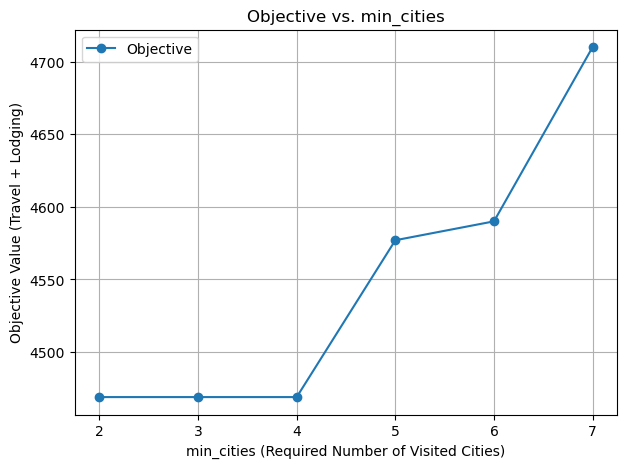

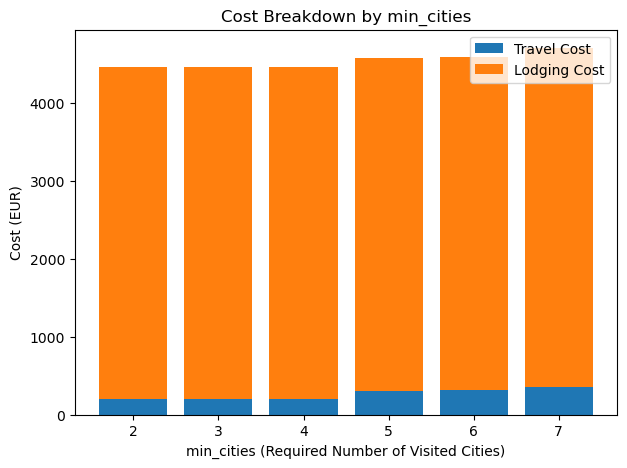

In [65]:
# Example usage:
min_cities_values = [2, 3, 4, 5, 6, 7]

analysis_results = run_sensitivity_analysis_on_min_cities(
    min_cities_values=min_cities_values,
    start_city_name="Rome",
    total_days=20,
    df_routes=df_routes,
    df_cities=df_cities,
    beach_set=beach_set,
    mountain_set=mountain_set,
    transport_mode=None,  # combine flight/train/bus
    user_budget= 5000,
    need_beach=False,
    need_mountain=False,
    user_min_temp=10,
    user_max_temp=35,
    hotel_type="luxury",
    user_daily_lodging_max=500,
    diversity_fraction=0.5
)

df_sens_mc = pd.DataFrame(analysis_results)
print(df_sens_mc[["min_cities","status","objective","visited_names","travel_cost","lodging_cost"]])

# Plot
plot_min_cities_sensitivity(df_sens_mc)



The first plot shows how the total cost (objective) remains relatively stable (flat) from min_cities = 2 to about min_cities = 4, then jumps sharply at min_cities = 5 and again at min_cities = 7. In practical terms, this means requiring more than 4 distinct cities in the trip triggers a noticeable increase in total travel + lodging costs. From a travel agency’s viewpoint, it suggests that if a customer wants to see 5 or more cities, the cost rises disproportionately—likely due to extra lodging nights, additional transport arcs, or less flexibility in choosing cheaper cities.

Business Insights

Trade-off: If a traveler wants to visit many cities in a short time (e.g., 6 or 7), they should expect a significant cost jump. We can show clients that “5 or fewer cities keeps you within a certain cost range, but once you go beyond that, the price climbs rapidly”.

Customer Decision-Making: If the traveler’s budget is fixed, pushing min_cities too high might make the trip infeasible or cause them to skip better-located or cheaper cities.

EuroTravel could recommend capping the number of cities at around 5 if the traveler’s budget is constrained—since the charts show stable cost up to that point, but a steep rise afterward.


# Discussion, Limitations, and Future Implementations

The selective Traveling Salesman Problem (TSP) approach described in this project provides a powerful framework for planning multi-city European trips. By integrating transportation costs (flight, train, or bus) and lodging expenses (budget, mid-range, or luxury) into a single optimization model, it effectively captures the core aspects of a traveler’s decision process. The solution includes constraints for ensuring a single valid cycle (via subtour elimination), a fixed total number of days, temperature and lodging filters, as well as optional requirements such as visiting a beach or mountain city. This combination of constraints and objective function is well-suited to deliver an optimized itinerary under typical travel scenarios.

However, the model has certain limitations that reflect the simplifying assumptions made for this prototype. First, it assumes static costs and times for flights, trains, and buses, whereas in reality, prices and schedules can vary by day or season. Additionally, the model does not factor in real-time seat availability or hotel vacancies, nor does it account for partial-day constraints (e.g., a midday arrival or departure). Another limitation arises in the computational complexity: as the number of potential cities and arcs grows, solving a TSP-based ILP can become computationally expensive. Large-scale instances might therefore require specialized heuristics or metaheuristics to reach a near-optimal solution in reasonable time. Lastly, the current model focuses primarily on cost minimization, ignoring potential multi-objective trade-offs such as carbon emissions, user enjoyment, or balancing budget vs. travel time.

Moving forward, future implementations could address these limitations in several ways. Integrating real-time flight and hotel APIs would allow dynamic cost and availability updates, making the itineraries more accurate. A day-by-day scheduling component could be introduced to handle partial-day arrivals, event timings, or time windows. If users have specific preferences—such as prioritizing scenic routes over the cheapest routes—a multi-objective approach (e.g., cost vs. travel time vs. carbon footprint) could be explored. Moreover, advanced constraints, such as limiting daily travel hours or imposing a maximum distance for bus rides, would enhance realism. Finally, to handle larger sets of European cities, heuristic methods (like genetic algorithms or large neighborhood search) may be necessary to ensure the solution can be computed within a practical timeframe, preserving the model’s utility for commercial deployment.






